In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install keract

In [4]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.layers import Input

In [5]:
data_dir = "../input/kermany2018/OCT2017 /"
train_data_dir= '../input/kermany2018/OCT2017 /train/'
val_data_dir= '../input/kermany2018/OCT2017 /val/'
test_data_dir= '../input/kermany2018/OCT2017 /test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [8]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

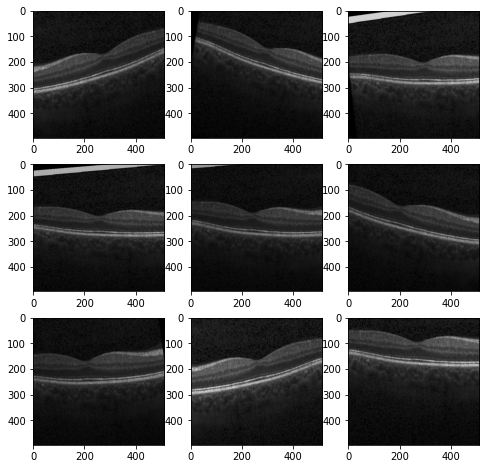

In [9]:
img = load_img('../input/kermany2018/OCT2017 /train/NORMAL/NORMAL-1001772-4.jpeg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)
plt.rcParams['figure.figsize'] = (8.0, 8.0)

for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0]
	plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [10]:
t_x, t_y = next(train_generator)

In [11]:
def resnet_model():
    img_in = Input(t_x.shape[1:])              
    model = ResNet101(include_top= False , 
                weights='imagenet',      
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 
    x = model.output  
    predictions = Dense(4, activation="softmax", name="predictions")(x)    # fully connected layer for predict class 
    model = Model(inputs=img_in, outputs=predictions)
    return model

In [12]:
# compiling model
model = resnet_model()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['accuracy'])

171450368/171446536 [==============================] - 1s 0us/step


In [14]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [15]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30
2608/2608 - 1244s - loss: 0.3244 - accuracy: 0.8954 - val_loss: 0.7859 - val_accuracy: 0.7188

Epoch 00001: val_loss improved from inf to 0.78592, saving model to baseline_model.h5
Epoch 2/30
2608/2608 - 887s - loss: 0.2242 - accuracy: 0.9263 - val_loss: 0.0649 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.78592 to 0.06492, saving model to baseline_model.h5
Epoch 3/30
2608/2608 - 886s - loss: 0.1983 - accuracy: 0.9345 - val_loss: 0.1154 - val_accuracy: 0.9375

Epoch 00003: val_loss did not improve from 0.06492
Epoch 4/30
2608/2608 - 896s - loss: 0.1812 - accuracy: 0.9392 - val_loss: 0.1890 - val_accuracy: 0.9062

Epoch 00004: val_loss did not improve from 0.06492
Epoch 5/30
2608/2608 - 889s - loss: 0.1699 - accuracy: 0.9426 - val_loss: 0.0318 - val_accuracy: 1.0000

Epoch 00005: val_loss improved from 0.06492 to 0.03178, saving model to baseline_model.h5
Epoch 6/30
2608/2608 - 895s - loss: 0.1655 - accuracy: 0.9444 - val_loss: 20.6490 - val_accuracy: 0.8125



In [16]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 10s 322ms/step - loss: 0.1791 - accuracy: 0.9225
Test Loss:  0.17914074659347534
Test Accuracy:  0.922520637512207


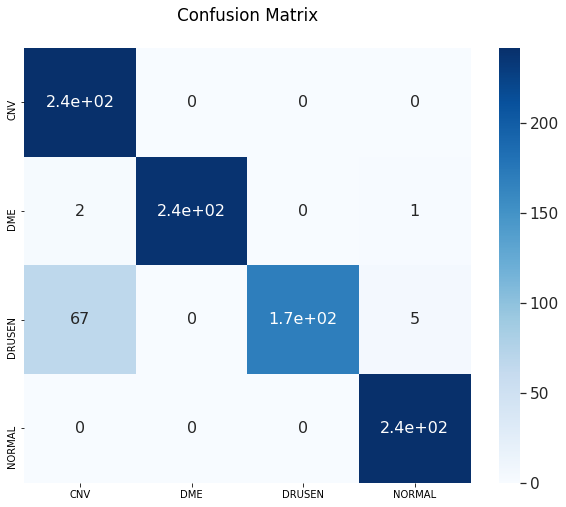

Classification Report

              precision    recall  f1-score   support

         CNV       0.78      1.00      0.88       242
         DME       1.00      0.99      0.99       242
      DRUSEN       1.00      0.70      0.83       242
      NORMAL       0.98      1.00      0.99       242

    accuracy                           0.92       968
   macro avg       0.94      0.92      0.92       968
weighted avg       0.94      0.92      0.92       968



In [17]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()
print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))